In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import core.utils as utils
import core.bayes as bayes
import core.scattering as scattering

use torch backend


## Validation data

In [2]:
data = np.load('data/weak_lensing.npy')

In [3]:
s = utils.preprocessing_weak_lensing(data)
n = np.random.randn(*s.shape)
d = s + n

In [4]:
torch.save((torch.tensor(s), torch.tensor(d)), 'data/weak_lensing.pt')

In [2]:
s, d = torch.load('data/weak_lensing.pt')
s, d = s.cuda(), d.cuda()

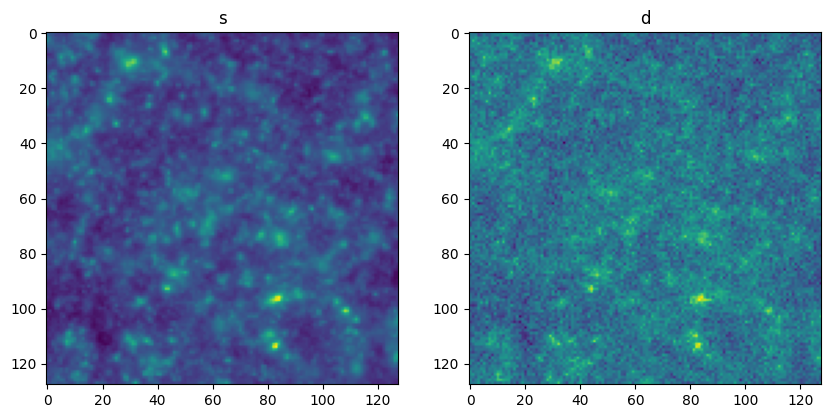

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(s[0].cpu())
ax2.imshow(d[0].cpu())
ax1.set_title("s")
ax2.set_title("d")
plt.show()

## Metrics

1. Main metric is a log-likelihood of validation data. More concretely, we are always going to model $p(\phi(s_0)|d_0) = \mathcal{N}(\mu_\phi, \sigma_\phi^2)$, where $\mu_\phi$ and $\sigma_\phi^2$ are going to be found by various methods. Then we calculate log-likelihood for each statistic as 
$$
    l_\phi = -\frac{1}{2}\log 2\pi\sigma_\phi^2 - \frac{(\phi(s_0) - \mu_\phi)^2}{2\sigma_\phi^2}
$$
where $\phi(s_0)$ are statistics of an original clean image. Then we can calculate average log-likelihood over all statistics or with a certain scale $j$. The larger it is the better.

2. Second metric is a variance criterion and it is a complementary one. We are going to compare for each statistic two values $\text{Var}_{s\sim p(s)}\mathbb{E}_n \phi(s+n)$ and $\text{Var}_n \phi(s_0 + n)$. Here first variance is taken over a distribution $p(s)$, which is defined separately by each method, and represents a guess of how reconstruced images $s$ can look like, such that $s + n$ looks like $d_0$. Then we are going to average variances over scale $j$ and calculate ratio 
$$
    \xi_j = \frac{\langle\text{Var}_n \phi(s_0 + n)\rangle_{\phi\in j}}{\langle\text{Var}_{s\sim p(s)}\mathbb{E}_n \phi(s+n)\rangle_{\phi\in j}}
$$
The closer $\xi_j$ to 1 the better. If $\xi_j$ is too small, $p(s)$ is too broad and we have too large errorbars. If $\xi_j$ is too large, $p(s)$ has small diversity and it is likely that predictions bias is much larger than predicted errobars.

## Baseline

We try to sample different realizations from $p(\phi(s_0)|d_0)$ by performing following procedure:
1. Denoise $d_0$ by performing gradient descent with loss $\mathcal{L} = \mathbb{E}_n||\phi(s + n) - \phi(d_0)||^2\to\min$ starting from white noise image $s$
2. Calculate WPH statistics $\phi$ of reconstructed image $\tilde{s}$

In [3]:
wph_op = bayes.create_wph_operator(d[0])
d_coeffs = wph_op.apply(d[0], norm='auto')

In [ ]:
sample_size = 5
loss_threshold = 10
y_list = []

while len(y_list) < sample_size:
    y, loss = bayes.denoise(wph_op, d_coeffs, np.random.randn(*d[0].shape), verbose=False)
    if loss < loss_threshold:
        y_list.append(y)
        
y_list = np.stack(y_list)

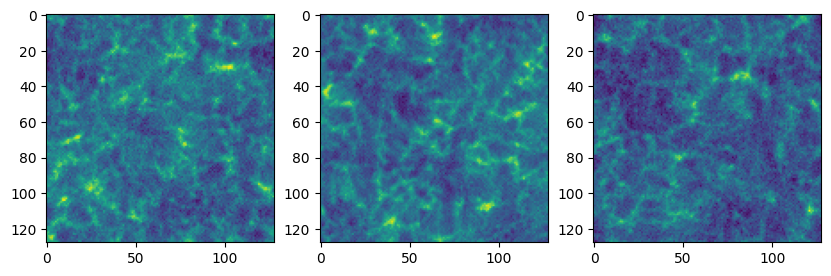

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

for ax, y in zip(axs, y_list):
    ax.imshow(y)
    
plt.show()

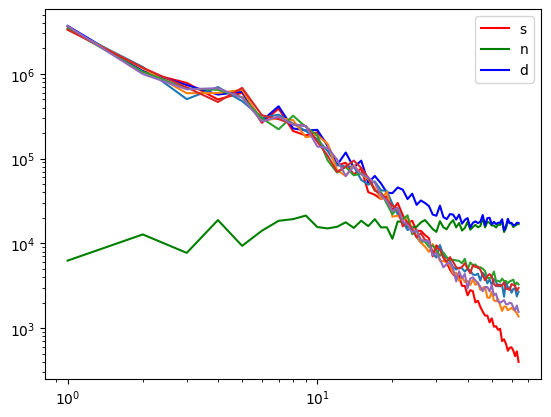

In [10]:
for x, name, c in zip([s[0], d[0] - s[0], d[0]], ["s", "n", "d"], ["r", "g", "b"]):
    k, bins = utils.power_spectrum(x.cpu())
    plt.loglog(k, bins, label=name, c=c)
    
for y in y_list:
    k, bins = utils.power_spectrum(y)
    plt.loglog(k, bins)
    
plt.legend()
plt.show()

In [69]:
triv_mask = bayes.get_triviality_mask(wph_op, s[0])
loglike = bayes.loglikelihood(wph_op, y_list, s[0])
loglike_list = bayes.aggregate_metric(wph_op, s[0], loglike, triv_mask)

In [70]:
loglike_list

array([[-2.06253111, -0.86617775, -1.59679233,  1.6314685 ,  2.52051227,
         1.16621878],
       [ 1.52107552, -1.04639064,  0.27498964,  1.69441513,  2.64239864,
         1.75205526]])

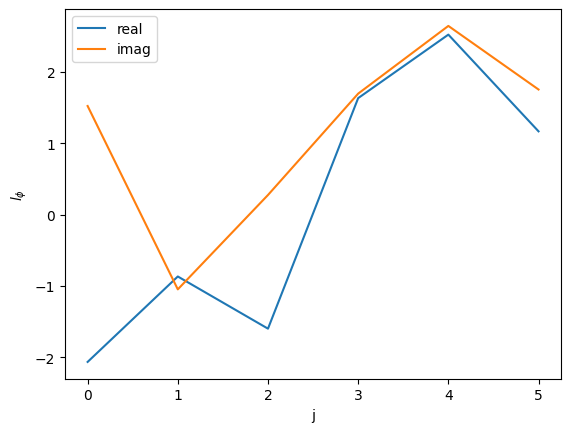

In [71]:
plt.plot(loglike_list[0], label="real")
plt.plot(loglike_list[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$l_\phi$")
plt.legend()
plt.show()

In [72]:
true_var, sample_var = bayes.variance(wph_op, y_list, s[0].cpu().numpy())
true_var_list = bayes.aggregate_metric(wph_op, s[0], true_var, triv_mask)
sample_var_list = bayes.aggregate_metric(wph_op, s[0], sample_var, triv_mask)
xi = true_var_list / sample_var_list

In [73]:
xi

array([[1.55386448, 2.72005661, 1.57870956, 1.29149114, 2.27543459,
        1.29870533],
       [1.50187357, 2.71771826, 1.50324894, 1.28547041, 2.29391778,
        1.39734889]])

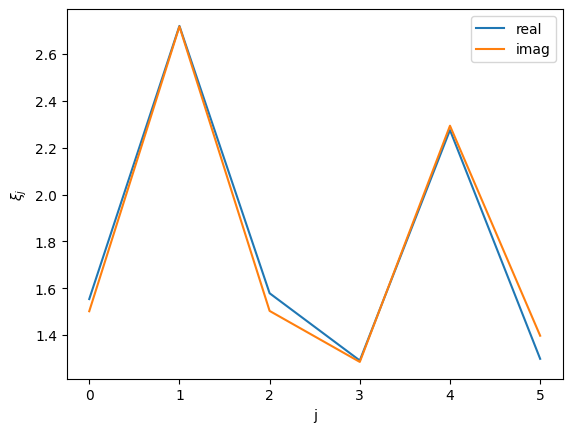

In [74]:
plt.plot(xi[0], label="real")
plt.plot(xi[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$\xi_j$")
plt.legend()
plt.show()

In [19]:
np.save('logs/images/y_list.npy', y_list)

In [3]:
y_list = np.load('logs/images/y_list.npy')

## Power spectrum diversity

We adapt the same sampling mechanism as in baseline with one important change. Instead of always starting from white noise, we sample power spectrum $P(k)$, then gaussian field with such power spectrum and use it as an initial condition. Sampling of power spectrum is done by taking high scale part from some reconstructed image $\tilde{s}$ and continuing it in low scales by a straight line with varying slope

In [14]:
loss_threshold = 10
slope_list = -np.arange(0, 10, 0.5)

init_list = bayes.sample_gaussian_init_cond(y_list[0], np.random.randn(*y_list[0].shape), slope_list)
ps_list = []

for y0 in init_list:
    loss = loss_threshold    
    while loss >= loss_threshold:
        y, loss = bayes.denoise(wph_op, d_coeffs, y0, verbose=False)        
    ps_list.append(y)
    
ps_list = np.stack(ps_list)

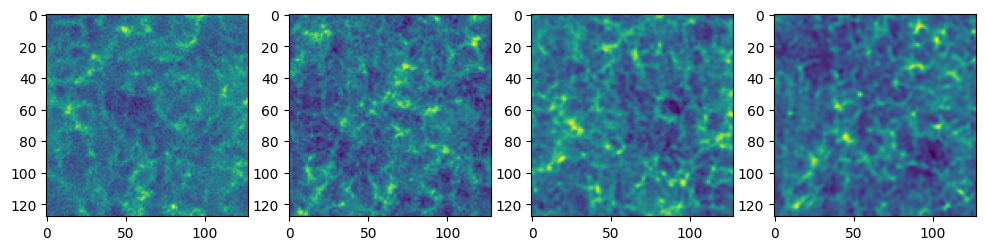

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

for ax, y in zip(axs, ps_list[::5]):
    ax.imshow(y)
    
plt.show()

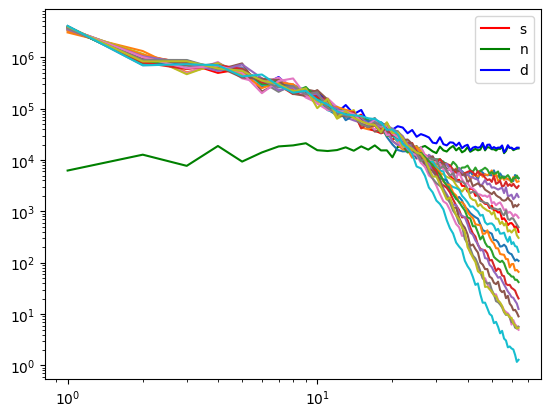

In [16]:
for x, name, c in zip([s[0], d[0] - s[0], d[0]], ["s", "n", "d"], ["r", "g", "b"]):
    k, bins = utils.power_spectrum(x.cpu())
    plt.loglog(k, bins, label=name, c=c)
    
for y in ps_list:
    k, bins = utils.power_spectrum(y)
    plt.loglog(k, bins)
    
plt.legend()
plt.show()

In [75]:
triv_mask = bayes.get_triviality_mask(wph_op, s[0])
loglike = bayes.loglikelihood(wph_op, ps_list, s[0])
loglike_list = bayes.aggregate_metric(wph_op, s[0], loglike, triv_mask)

In [76]:
loglike_list

array([[1.29237378, 2.58141825, 1.3144947 , 2.30416353, 3.28792988,
        1.63959059],
       [2.90836292, 2.81416168, 2.09620986, 2.53302362, 3.29520796,
        1.85784664]])

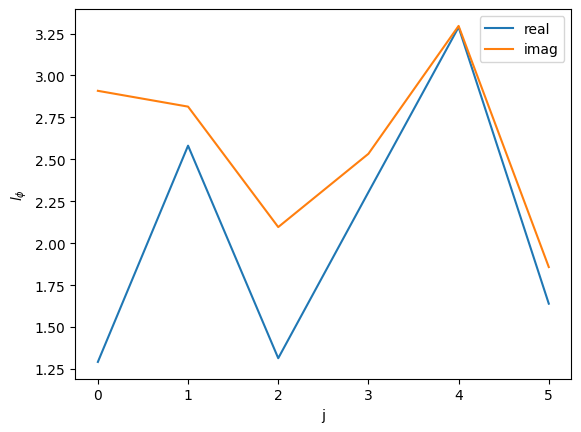

In [77]:
plt.plot(loglike_list[0], label="real")
plt.plot(loglike_list[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$l_\phi$")
plt.legend()
plt.show()

In [78]:
true_var, sample_var = bayes.variance(wph_op, ps_list, s[0].cpu().numpy())
true_var_list = bayes.aggregate_metric(wph_op, s[0], true_var, triv_mask)
sample_var_list = bayes.aggregate_metric(wph_op, s[0], sample_var, triv_mask)
xi = true_var_list / sample_var_list

In [79]:
xi

array([[1.24837096, 2.36209838, 1.28361961, 1.14606692, 2.27801814,
        1.08214914],
       [1.11626669, 2.3340575 , 1.27045257, 1.18873184, 2.17157424,
        1.09477932]])

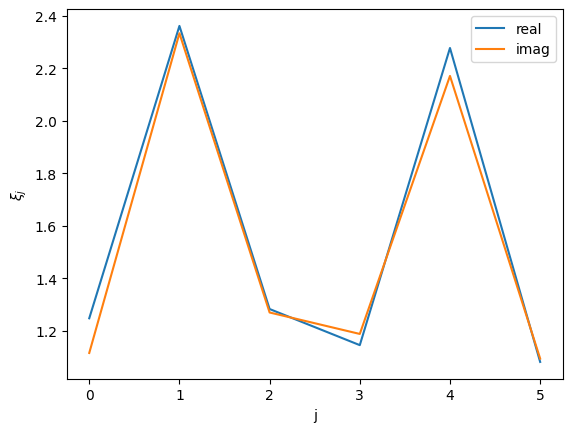

In [80]:
plt.plot(xi[0], label="real")
plt.plot(xi[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$\xi_j$")
plt.legend()
plt.show()

In [23]:
np.save('logs/images/ps_list.npy', ps_list)

In [4]:
ps_list = np.load('logs/images/ps_list.npy')

## Variational Bayesian method

The method itself is derived and described in the report. We perform inference and then calculate same metrics. Instead of using WPH statistics as $\phi$, we use a concatenation of power spectrum and compressed statistics, which are provided by scattering library. 

The reduced number of statistics makes the method more stable and a hypothesis of statistic independence more realistic (it is employed by the Bayesian method when approximating statistic posterior by a gaussian and later in linear regression approximation).

In [5]:
image_target = scattering.whiten(ps_list, overall=True)

M, N = d[0].shape
J, L = 6, 4

st_calc = scattering.Scattering2d(M, N, J, L)
s_cov = scattering.chunk_model(image_target, st_calc, nchunks=10) 

threshold_list = [2]
_, _, _, threshold_func, mask_list = scattering.prepare_threshold_func(s_cov, threshold_list)
mask = mask_list[0]
mask.sum()

20


214

We check that compressed statistics are sufficient to restore an image which looks similar to the original one.

In [6]:
s_cov = st_calc.scattering_cov(ps_list[10:11])
P00 = torch.exp(s_cov['for_synthesis'][:,1:1 + J * L].mean(0).reshape((1, J, -1)))
stat = threshold_func(s_cov, mask)

img = scattering.synthesis(
        's_cov_func', mode='estimator', M=M, N=N, J=J, L=L,
        target=stat,
        s_cov_func=threshold_func, s_cov_func_params=mask,
        reference_P00=P00)[0].astype(np.float64)

# of estimators:  214
max residual:  5.682273864746094 , mean residual:  0.47556216796156336
max residual:  0.0002313088785181276 , mean residual:  4.1457317670869434e-05
time used:  24.36837863922119 s


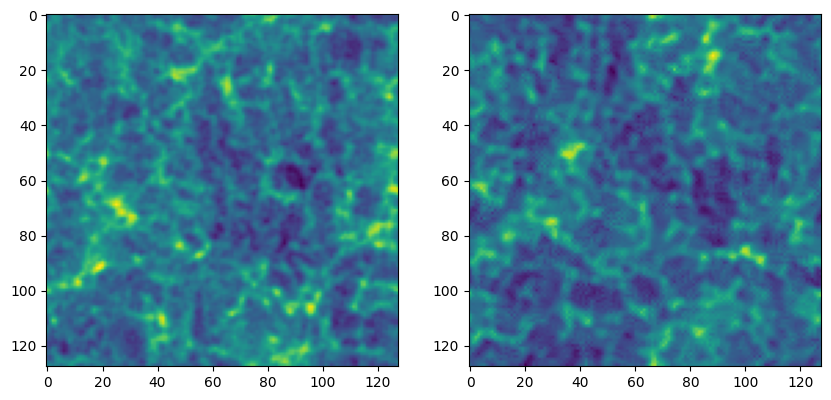

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(ps_list[10])
ax2.imshow(img)    
plt.show()

We choose $\eta$ such that $\mathbb{E}_q\text{Var}_n \phi(s + n)\approx\text{Var}_q\mathbb{E}_n\phi(s + n)$, which is denoted in a code by noise_var and sample_var, respectively.

In [47]:
var = bayes.VarBayes(st_calc, threshold_func, mask, ps_list, d[0], eta=1)
log = []

for _ in range(10):
    lin_reg_err = var.fit()
    var.generate()
    
    noise_var = torch.stack([var.calculate_stat(y + np.random.randn(var.noise_size, *y.shape)).std(dim=0)**2 for y in var.images[-1]])
    sample_var = torch.stack([var.calculate_stat(y + np.random.randn(var.noise_size, *y.shape)).mean(dim=0) for y in var.images[-1]]).std(dim=0)**2
    
    print('lin reg err', lin_reg_err.mean() * 1e8)
    print('norm lin reg err', (lin_reg_err / var.loss_coeff).mean())
    print('noise var', noise_var.mean() * 1e8, 'sample var', sample_var.mean() * 1e8)
    print('norm noise var', (noise_var / var.loss_coeff).mean(), 'norm sample var', (sample_var / var.loss_coeff).mean())
    log.append([lin_reg_err, noise_var, sample_var])

# of estimators:  214
max residual:  6.292724609375 , mean residual:  0.493370346229038
max residual:  0.10113203525543213 , mean residual:  0.0031006735900581486
time used:  24.94907808303833 s
# of estimators:  214
max residual:  5.917053699493408 , mean residual:  0.4938811568257093
max residual:  0.15047144889831543 , mean residual:  0.0044752821771412675
time used:  25.027498483657837 s
# of estimators:  214
max residual:  5.212799787521362 , mean residual:  0.47806147584769787
max residual:  0.004898325582997243 , mean residual:  0.0005505976479367364
time used:  25.058661222457886 s
# of estimators:  214
max residual:  5.711164236068726 , mean residual:  0.47465476346523994
max residual:  0.029275457949477036 , mean residual:  0.001976841013338396
time used:  25.083089351654053 s
# of estimators:  214
max residual:  5.754156112670898 , mean residual:  0.47122713088473855
max residual:  0.023196231388707356 , mean residual:  0.0015688207916362404
time used:  25.0491464138031 s
li

# of estimators:  214
max residual:  5.75796103477478 , mean residual:  0.4956160039673564
max residual:  0.11102461814880371 , mean residual:  0.002364865578942055
time used:  25.082416772842407 s
# of estimators:  214
max residual:  5.873210430145264 , mean residual:  0.47734861574572773
max residual:  0.053820133209228516 , mean residual:  0.0027643088024041224
time used:  25.034720182418823 s
# of estimators:  214
max residual:  6.638945817947388 , mean residual:  0.49100116786215736
max residual:  0.15747034549713135 , mean residual:  0.003117623336241737
time used:  25.082682371139526 s
# of estimators:  214
max residual:  5.237395763397217 , mean residual:  0.47891472506135124
max residual:  0.010418165242043892 , mean residual:  0.001639164356672966
time used:  25.121633052825928 s
# of estimators:  214
max residual:  6.144583702087402 , mean residual:  0.4831818825765142
max residual:  0.0995321273803711 , mean residual:  0.002613208515258794
time used:  25.053716897964478 s
l

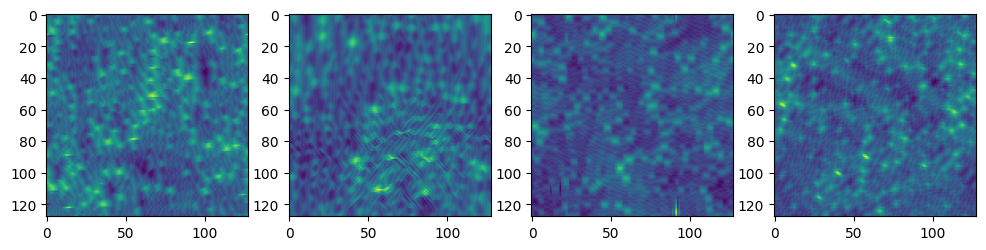

In [82]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

for ax, y in zip(axs, var_list[::5]):
    ax.imshow(y)
    
plt.show()

In [60]:
var_list = np.concatenate(var.images[-4:])
triv_mask = bayes.get_triviality_mask(wph_op, s[0])
loglike = bayes.loglikelihood(wph_op, var_list, s[0])
loglike_list = bayes.aggregate_metric(wph_op, s[0], loglike, triv_mask)

/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/pywph/wph_operator.py:803: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 = xpsi1_k1 - mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


In [68]:
loglike_list

array([[1.69497094, 2.72178809, 1.96011981, 1.98199125, 3.27872288,
        1.45478998],
       [2.56054834, 2.8905888 , 1.96870833, 2.02792289, 3.26379199,
        1.62156161]])

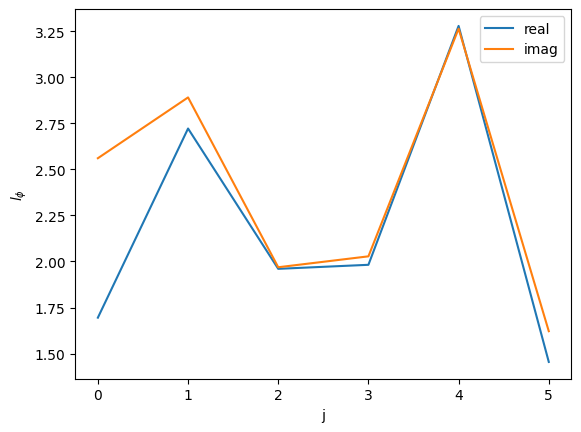

In [63]:
plt.plot(loglike_list[0], label="real")
plt.plot(loglike_list[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$l_\phi$")
plt.legend()
plt.show()

In [65]:
true_var, sample_var = bayes.variance(wph_op, var_list, s[0].cpu().numpy())
true_var_list = bayes.aggregate_metric(wph_op, s[0], true_var, triv_mask)
sample_var_list = bayes.aggregate_metric(wph_op, s[0], sample_var, triv_mask)
xi = true_var_list / sample_var_list

In [67]:
xi

array([[0.34009904, 1.03288158, 0.45616324, 0.39984229, 1.31659217,
        0.41003102],
       [0.57500263, 1.17228954, 0.47461376, 0.3399671 , 1.31336812,
        0.43532266]])

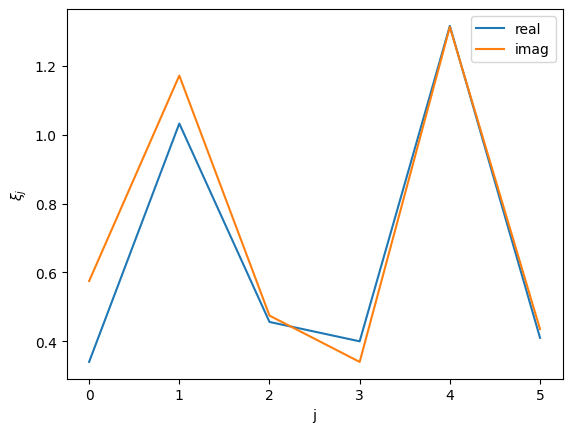

In [66]:
plt.plot(xi[0], label="real")
plt.plot(xi[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$\xi_j$")
plt.legend()
plt.show()

In [81]:
np.save('logs/images/var_list.npy', var_list)

## Finetuning

Now we use images generated by variational Bayesian method as an initial condition for a baseline sampling, in an analogy with choosing initial conditions having different power spectrum.

In [84]:
var_tune_list = []

for y0 in var_list:
    loss = loss_threshold    
    while loss >= loss_threshold:
        y, loss = bayes.denoise(wph_op, d_coeffs, y0, verbose=False)        
    var_tune_list.append(y)
    
var_tune_list = np.stack(var_tune_list)

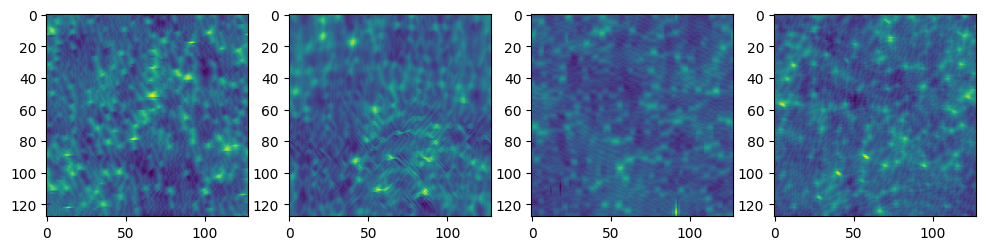

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

for ax, y in zip(axs, var_tune_list[::5]):
    ax.imshow(y)
    
plt.show()

In [87]:
triv_mask = bayes.get_triviality_mask(wph_op, s[0])
loglike = bayes.loglikelihood(wph_op, var_tune_list, s[0])
loglike_list = bayes.aggregate_metric(wph_op, s[0], loglike, triv_mask)

In [88]:
loglike_list

array([[2.16126381, 2.91473781, 1.34656368, 2.63899316, 3.25969516,
        1.76588413],
       [3.12590042, 2.86171011, 1.86358955, 2.57239791, 3.26139518,
        1.9917109 ]])

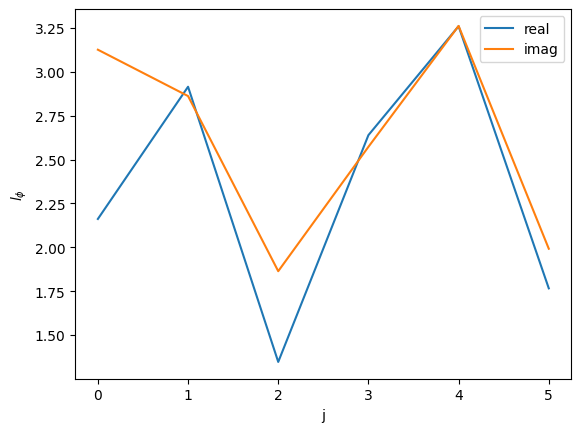

In [89]:
plt.plot(loglike_list[0], label="real")
plt.plot(loglike_list[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$l_\phi$")
plt.legend()
plt.show()

In [90]:
true_var, sample_var = bayes.variance(wph_op, var_tune_list, s[0].cpu().numpy())
true_var_list = bayes.aggregate_metric(wph_op, s[0], true_var, triv_mask)
sample_var_list = bayes.aggregate_metric(wph_op, s[0], sample_var, triv_mask)
xi = true_var_list / sample_var_list

In [91]:
xi

array([[1.31783098, 1.97079988, 1.27624871, 1.2146926 , 2.11319515,
        1.09367004],
       [1.12812206, 2.15806739, 1.29035455, 1.20762368, 2.13665691,
        1.13588012]])

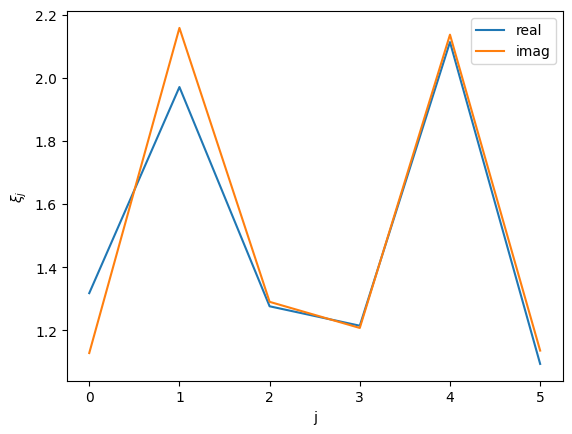

In [92]:
plt.plot(xi[0], label="real")
plt.plot(xi[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$\xi_j$")
plt.legend()
plt.show()

In [93]:
np.save('logs/images/var_tune_list.npy', var_tune_list)

## Macro-canonical denoising

Details can be found in the report and macro.ipynb notebook, where denoised images are generate. Here we just calculate metrics on the images.

In [4]:
macro_list = torch.load('logs/synthesis/128_weak_lensing128_synth.pt').numpy()

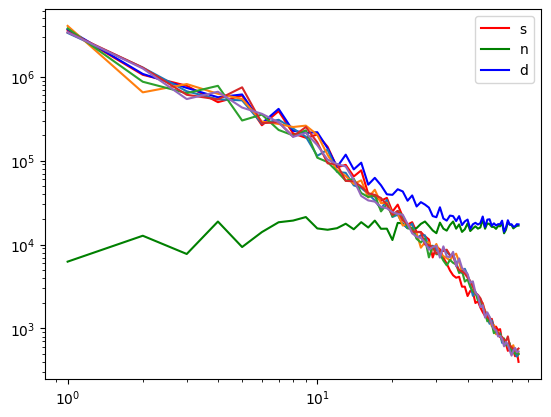

In [6]:
for x, name, c in zip([s[0], d[0] - s[0], d[0]], ["s", "n", "d"], ["r", "g", "b"]):
    k, bins = utils.power_spectrum(x.cpu())
    plt.loglog(k, bins, label=name, c=c)
    
for y in macro_list[::4]:
    k, bins = utils.power_spectrum(y)
    plt.loglog(k, bins)
    
plt.legend()
plt.show()

In [7]:
triv_mask = bayes.get_triviality_mask(wph_op, s[0])
loglike = bayes.loglikelihood(wph_op, macro_list, s[0])
loglike_list = bayes.aggregate_metric(wph_op, s[0], loglike, triv_mask)

/obs/rsoletskyi/miniconda3/lib/python3.10/site-packages/pywph/wph_operator.py:803: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 = xpsi1_k1 - mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


In [8]:
loglike_list

array([[-0.13601953,  1.72459252,  1.90764555,  1.61744129,  2.77692819,
         1.7504766 ],
       [ 1.25973542,  2.26907613,  2.02640816,  2.44170139,  2.56222223,
         1.86416496]])

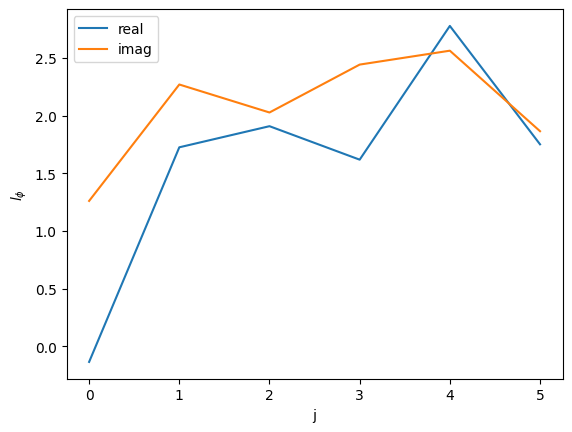

In [9]:
plt.plot(loglike_list[0], label="real")
plt.plot(loglike_list[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$l_\phi$")
plt.legend()
plt.show()

In [10]:
true_var, sample_var = bayes.variance(wph_op, macro_list, s[0].cpu().numpy())
true_var_list = bayes.aggregate_metric(wph_op, s[0], true_var, triv_mask)
sample_var_list = bayes.aggregate_metric(wph_op, s[0], sample_var, triv_mask)
xi = true_var_list / sample_var_list

In [11]:
xi

array([[1.02461567, 1.42997678, 0.63986705, 0.88220858, 1.54177047,
        0.58075149],
       [0.97695147, 1.58425034, 0.67147706, 0.8551274 , 1.55005401,
        0.62187636]])

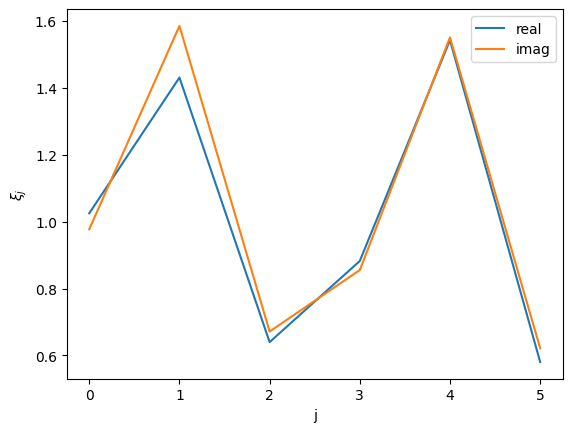

In [12]:
plt.plot(xi[0], label="real")
plt.plot(xi[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$\xi_j$")
plt.legend()
plt.show()

## Miyasawa denoising

Details can be found in the report and macro.ipynb notebook

In [5]:
macrom_list = torch.load('logs/synthesis/128_weak_lensing_miyasawa128_synth.pt').cpu().numpy()

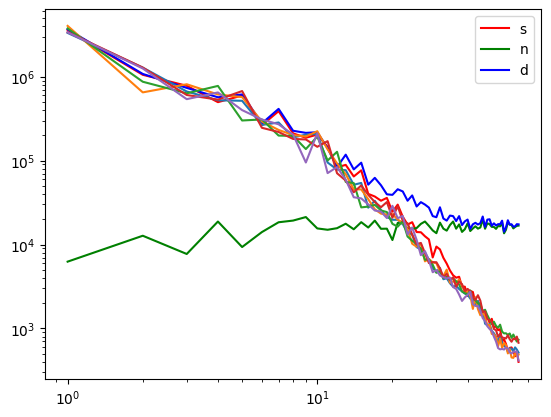

In [6]:
for x, name, c in zip([s[0], d[0] - s[0], d[0]], ["s", "n", "d"], ["r", "g", "b"]):
    k, bins = utils.power_spectrum(x.cpu())
    plt.loglog(k, bins, label=name, c=c)
    
for y in macrom_list[::4]:
    k, bins = utils.power_spectrum(y)
    plt.loglog(k, bins)
    
plt.legend()
plt.show()

In [10]:
triv_mask = bayes.get_triviality_mask(wph_op, s[0])
loglike = bayes.loglikelihood(wph_op, macrom_list, s[0])
loglike_list = bayes.aggregate_metric(wph_op, s[0], loglike, triv_mask)

In [11]:
loglike_list

array([[-0.44005486, -2.33505071, -0.76187392,  1.13020928,  1.99851158,
        -0.33775864],
       [ 0.43184119,  0.81038957,  1.16911942,  2.09708019,  2.10604453,
         0.29420736]])

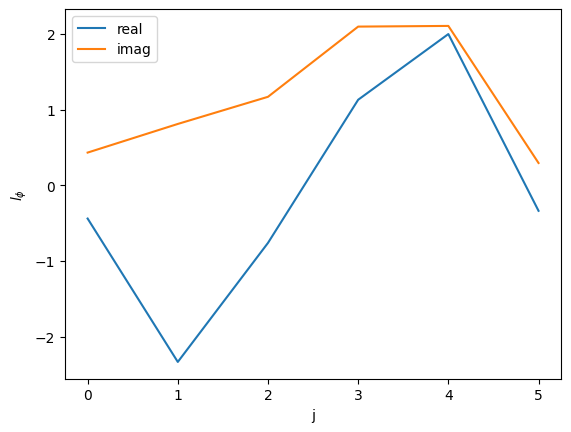

In [12]:
plt.plot(loglike_list[0], label="real")
plt.plot(loglike_list[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$l_\phi$")
plt.legend()
plt.show()

In [14]:
true_var, sample_var = bayes.variance(wph_op, macrom_list, s[0].cpu().numpy())
true_var_list = bayes.aggregate_metric(wph_op, s[0], true_var, triv_mask)
sample_var_list = bayes.aggregate_metric(wph_op, s[0], sample_var, triv_mask)
xi = true_var_list / sample_var_list

In [15]:
xi

array([[1.11225306, 1.64002016, 0.63580479, 0.87709095, 1.91592976,
        0.66656591],
       [1.02173047, 1.69245044, 0.6655532 , 0.91053477, 1.88003956,
        0.67232557]])

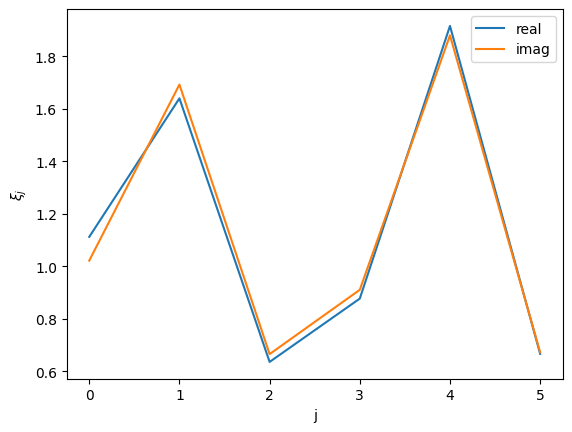

In [16]:
plt.plot(xi[0], label="real")
plt.plot(xi[1], label="imag")
plt.xlabel("j")
plt.ylabel(r"$\xi_j$")
plt.legend()
plt.show()